In [148]:
text_data = open('/media/ihdav/Files/Research/Infrrd_Research/chatGPT/Data/Tiny_Shakespeare/input.txt','r',encoding='utf-8').read()
print(len(text_data))

1115394


In [149]:
print(text_data[:500])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us kill him, and we'll have corn at our own price.
Is't a verdict?

All:
No more talking on't; let it be done: away, away!

Second Citizen:
One word, good citizens.

First Citizen:
We are accounted poor


In [150]:
vocab = sorted(list(set(text_data)))
vocab_size = len(vocab)

print(f'Vocabulary Size: {vocab_size}')
print(f'Vocabulary {" ".join(vocab)}')

Vocabulary Size: 65
Vocabulary 
   ! $ & ' , - . 3 : ; ? A B C D E F G H I J K L M N O P Q R S T U V W X Y Z a b c d e f g h i j k l m n o p q r s t u v w x y z


In [151]:
stoi = {s:i for i,s in enumerate(vocab)}
itos = {i:s for s,i in stoi.items()}

encode = lambda s: [stoi[ch] for ch in s]
decode = lambda i: "".join([itos[i_t] for i_t in i])

In [152]:
import torch

Data = torch.tensor(encode(text_data),dtype=torch.long)
print(Data.shape,Data.dtype)

torch.Size([1115394]) torch.int64


In [153]:
n = int(0.9*len(Data))
train_data = Data[:n]
val_data = Data[n:]

In [154]:
block_size = 8
text_data[:block_size+1],encode(text_data[:block_size+1])

('First Cit', [18, 47, 56, 57, 58, 1, 15, 47, 58])

In [155]:
text_data[:block_size+1],text_data[1:block_size+1+1]

('First Cit', 'irst Citi')

In [156]:
train_data[:block_size+1],train_data[1:block_size+1]

(tensor([18, 47, 56, 57, 58,  1, 15, 47, 58]),
 tensor([47, 56, 57, 58,  1, 15, 47, 58]))

In [157]:
x = text_data[:block_size+1]
y = text_data[1:block_size+1]

for t in range(block_size):
    context = encode(x[:t+1])
    target = encode(y[t])
    print(f'When input is {context} then output must be {target}')


When input is [18] then output must be [47]
When input is [18, 47] then output must be [56]
When input is [18, 47, 56] then output must be [57]
When input is [18, 47, 56, 57] then output must be [58]
When input is [18, 47, 56, 57, 58] then output must be [1]
When input is [18, 47, 56, 57, 58, 1] then output must be [15]
When input is [18, 47, 56, 57, 58, 1, 15] then output must be [47]
When input is [18, 47, 56, 57, 58, 1, 15, 47] then output must be [58]


In [158]:
#Creating Batches
torch.manual_seed(1337)
batch_size = 4 
block_size = 8

def get_batch(split):
    data = train_data if split=="train" else val_data
    ix = torch.randint(data.shape[0]-block_size,(batch_size,1))

    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])

    return x,y

xb,yb = get_batch('train')

In [159]:
for i in range(batch_size):
    for k in range(block_size):
        context = xb[i,:k+1].tolist()
        target = yb[i,k].tolist()

        print(f'Context: {decode(context)} Target: {decode([target])}')

Context: L Target: e
Context: Le Target: t
Context: Let Target: '
Context: Let' Target: s
Context: Let's Target:  
Context: Let's  Target: h
Context: Let's h Target: e
Context: Let's he Target: a
Context: f Target: o
Context: fo Target: r
Context: for Target:  
Context: for  Target: t
Context: for t Target: h
Context: for th Target: a
Context: for tha Target: t
Context: for that Target:  
Context: n Target: t
Context: nt Target:  
Context: nt  Target: t
Context: nt t Target: h
Context: nt th Target: a
Context: nt tha Target: t
Context: nt that Target:  
Context: nt that  Target: h
Context: M Target: E
Context: ME Target: O
Context: MEO Target: :
Context: MEO: Target: 

Context: MEO:
 Target: I
Context: MEO:
I Target:  
Context: MEO:
I  Target: p
Context: MEO:
I p Target: a


Bigram Language Model

In [160]:
import torch.nn as nn
import torch.nn.functional as F

class BigramLanguageModel(nn.Module):
    
    def __init__(self,vocab_size):
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size,vocab_size) # A matrix M (C,C)
    
    def forward(self,idx,target=None):
        logits = self.token_embedding_table(idx) # (B,T,C)

        # B => Batch_Size | Number of samples per batch
        # T => Times or Block_Size | length of the idx
        # C => Vocab_Size or size of the vector

        if target==None:
            loss = None
        else:
            logits = logits.view(batch_size*block_size,vocab_size)
            target = target.view(batch_size*block_size)

            loss = F.cross_entropy(logits,target)
        
            
        return logits,loss
    
    def generate(self,idx,max_new_tokens):
        #idx is (B,T)

        for i in range(max_new_tokens):
            logits,loss =  self(idx)

            #logits => (B1,T1,C)

            #Have to focus only on the last case
            logits = logits[:,-1,:] #(B1,C1)

            probs = F.softmax(logits,dim=1) #Applying softmax along the C that is dimension 1

            idx_next = torch.multinomial(probs,num_samples=1) #(B1,1)
            
            idx = torch.cat((idx,idx_next),dim=1) #(B1,T1+1)
        
        return idx #(B1,T1+max_new_tokens)
    
m = BigramLanguageModel(vocab_size=vocab_size)
out = m(xb,yb)
out

(tensor([[ 1.6347, -0.0518,  0.4996,  ...,  0.2432,  1.1519,  0.9950],
         [ 0.3418, -0.9276,  1.2381,  ...,  1.5018, -0.5266,  0.2354],
         [ 0.1479, -0.4333,  0.5203,  ...,  0.3302,  1.5454,  1.3778],
         ...,
         [-0.5693, -0.0735,  0.7743,  ..., -0.0815, -1.1445, -0.0623],
         [ 0.4658, -0.2573, -1.0673,  ...,  1.2439,  1.3471,  1.6910],
         [-0.4553,  0.0139,  0.9309,  ...,  0.0290, -0.7568,  0.8701]],
        grad_fn=<ViewBackward0>),
 tensor(5.0364, grad_fn=<NllLossBackward0>))

In [161]:
optimizer = torch.optim.AdamW(m.parameters(),lr=1e-3)

In [162]:
batch_size = 32
lossess = []
for steps in range(10000):
    xb,yb = get_batch('train')

    logits,loss = m(xb,yb)
    
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()
    lossess.append(loss.item())

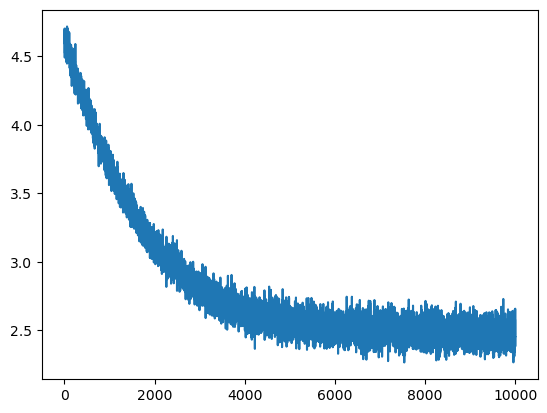

In [163]:
import matplotlib.pyplot as plt
plt.plot(lossess)

In [164]:
lossess[-1]

2.4487955570220947

In [165]:
idx = torch.zeros((1,1),dtype=torch.long)
print(decode(m.generate(idx,1000)[0].tolist()))



Thidin y y arermet hn y, denjohece w illd CHAL, mer thoun s's:
Thicuntilalllevise sthat dy hangilyoteng h hasbe pave pirance
RDe hicomyonthar's
PES:
AKEd ith henourzincenonthioneir thondy, y heltieiengerofo'dsssit ey
KINld pe wither vouprroutherccnohathe; d!
My hind tt hinig t ouchos tes; st yo hind wotte grotonear 'so itJas
Waketancotha:
h hay.JUCLUKn prids, r loncave w hollular s O:
HIs; ht anjx?

DUThinqunt.

LaZEESTEORDY:
h l.
KEONGBUCHandspo be y,-JZNEEYowddy scace, tridesar, wnl'shenous s ls, theresseys
PlorseelapinghienHen yof GLANCHI me. strsithisgothers jveere!-e!
QUCotouciullle's fldrwertho s?
NDan'spererds cist ripl chyreer orlese;
Yo jowof h hecere ek? wferommot mowo soaf you f;
Ane his, t, f at. fal whetrimy bupof tor atha Bu!
JOutho fplimimave.
NEDUSt cir selle p wie wede
Ro n apenor f'Y tover witys an sh d w t e w!
CilttiretoaveE IINGAwe n ck. cung.
ORDUSURes hacin benqurd bll, d a r w wistatsowor ath
Fivet bloll ang aror;
ARKIOULemee tsce larry t I Ane szF t
LCay thit,

Now converting the above code into a Python script

Mathematical Trick Used in Self-Attention.

In [166]:
torch.manual_seed(1337)

B,T,C = 4,8,2
x = torch.randn(B,T,C)
x.shape

torch.Size([4, 8, 2])

We want these tokens to talk to each other in causal manner. Depends only on t-1

simplest manner is to do the average.

In [167]:
x.view(B*T,C).shape

torch.Size([32, 2])

In [168]:
# For every x[b,t]->(1,C) we want to have sum(x[b,:t])->(1,C)

#xbagofwords

xbow = torch.zeros((B,T,C))

for i in range(x.shape[0]):
    for j in range(x.shape[1]):
        xbow[i,j] = x[i,:j+1].mean(0,keepdim=True)

print(xbow.shape)

torch.Size([4, 8, 2])


In [169]:
print(x[[0]])

tensor([[[ 0.1808, -0.0700],
         [-0.3596, -0.9152],
         [ 0.6258,  0.0255],
         [ 0.9545,  0.0643],
         [ 0.3612,  1.1679],
         [-1.3499, -0.5102],
         [ 0.2360, -0.2398],
         [-0.9211,  1.5433]]])


In [170]:
print(xbow[[0]])

tensor([[[ 0.1808, -0.0700],
         [-0.0894, -0.4926],
         [ 0.1490, -0.3199],
         [ 0.3504, -0.2238],
         [ 0.3525,  0.0545],
         [ 0.0688, -0.0396],
         [ 0.0927, -0.0682],
         [-0.0341,  0.1332]]])


In [171]:
#Causal Weights
wei = torch.tril(torch.ones((T,T)))
wei = wei/wei.sum(1,keepdim=True)
xbow_2 = wei @ x # (B,T,T) @ (B,T,C) => (B,T,C
# batching is done in memory

xbow_2[0]

tensor([[ 0.1808, -0.0700],
        [-0.0894, -0.4926],
        [ 0.1490, -0.3199],
        [ 0.3504, -0.2238],
        [ 0.3525,  0.0545],
        [ 0.0688, -0.0396],
        [ 0.0927, -0.0682],
        [-0.0341,  0.1332]])

In [172]:
torch.allclose(xbow,xbow_2,atol=1e-7)

True

Version 2

In [173]:
torch.manual_seed(42)

a = torch.ones((3,3))
a = torch.tril(a)/a.sum(0,keepdim=True)

# FOR AVERAGE
a = a/a.sum(1,keepdim=True)
b = torch.randint(0,10,(3,2)).float()
c = a @ b

print(f'a= \n {a}')
print(f'b= \n {b}')
print(f'c= \n {c}')

a= 
 tensor([[1.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000],
        [0.3333, 0.3333, 0.3333]])
b= 
 tensor([[2., 7.],
        [6., 4.],
        [6., 5.]])
c= 
 tensor([[2.0000, 7.0000],
        [4.0000, 5.5000],
        [4.6667, 5.3333]])


Version 3

In [174]:
tril = torch.tril(torch.ones((T,T)))

wei = torch.zeros((T,T)) #(Affinities)

#This is like the weightes aggregates, These depends on the data. 

wei = wei.masked_fill(tril==0,  float('-inf')) #This Line is implying the causal nature of the weights

wei = F.softmax(wei,dim=1)
xbow_3 = wei @ x
xbow_3[0]
torch.allclose(xbow,xbow_3,atol=1e-7)

True

Version 4 self-attention

In [175]:
torch.manual_seed(1337)
B,T,C = 4,8,32
x = torch.randn(B,T,C)

tril = torch.tril((torch.ones((T,T))))
head_size = 16

key = torch.nn.Linear(C,head_size)
query = torch.nn.Linear(C,head_size)
value = torch.nn.Linear(C,head_size)


k = key(x) # (B,T,head_size)
q = query(x) # (B,T,head_size)
v = value(x) # (B,T,head_size)

#let k and q be unit gaussian
# k = torch.randn((B,T,head_size))
# q = torch.randn((B,T,head_size))

# wei = torch.zeros((T,T))

#here we normalise the weights in order to take care the diffusion of the outputs
wei = k @ q.transpose(-2,-1)*(head_size**(-0.5)) # (B,T,head_size) @ (B,head_size,T) => (B,T,T)

wei = wei.masked_fill(tril==0,float('-inf'))
wei = F.softmax(wei,dim=-1)   # (B,T,T)

#x is like a private information of input
#v is like the information for this particular head
out = wei @ v #(B,T,T) @ (B,T,head_size) => (B,T,head_size)
out.shape

torch.Size([4, 8, 16])

In [176]:
k.var(),q.var(),x.var(),wei.var()

(tensor(0.3188, grad_fn=<VarBackward0>),
 tensor(0.3494, grad_fn=<VarBackward0>),
 tensor(1.0731),
 tensor(0.0284, grad_fn=<VarBackward0>))

In [177]:
wei

tensor([[[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.6253, 0.3747, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.2270, 0.3988, 0.3742, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.2753, 0.2068, 0.3019, 0.2160, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.1404, 0.2093, 0.1792, 0.2279, 0.2432, 0.0000, 0.0000, 0.0000],
         [0.2189, 0.1305, 0.1471, 0.1536, 0.1938, 0.1562, 0.0000, 0.0000],
         [0.1272, 0.0951, 0.1267, 0.1255, 0.1500, 0.2287, 0.1467, 0.0000],
         [0.1650, 0.1156, 0.1266, 0.0990, 0.1436, 0.1036, 0.1029, 0.1438]],

        [[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.4666, 0.5334, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.3195, 0.2411, 0.4394, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.3204, 0.3697, 0.1820, 0.1278, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.2115, 0.2108, 0.2268, 0.1813, 0.1697, 0.0000, 0.0000, 0.0000],
         [0.1276, 0.139

In [181]:
torch.softmax(torch.randn((1,4))*1000,dim=1)

tensor([[1.0000e+00, 0.0000e+00, 0.0000e+00, 9.6020e-31]])